In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
import numpy as np
import nltk  # Import NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

Imported different libraries to split data into test and training, for different models, and for tokenizing.


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
spam=pd.read_csv('spam_ham_dataset.csv')

In [4]:
z = spam['text']
y = spam["label"]
z_train, z_test,y_train, y_test = train_test_split(z,y,test_size = 0.3)

In [5]:
stop_words = set(stopwords.words('english'))

In [6]:
# Define a lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to perform lemmatization on a text
def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]
    return ' '.join(lemmatized_words)

# Apply lemmatization to z_train and z_test
z_train = z_train.apply(lemmatize_text)
z_test = z_test.apply(lemmatize_text)

In [7]:
cv = TfidfVectorizer();
features_train = cv.fit_transform(z_train)
features_test = cv.transform(z_test)

Measures how often a word appears in a document

In [8]:
model = svm.SVC(C=0.4)
model2 = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=0)
nb_classifier = MultinomialNB()

# Create the meta-model
meta_model = LogisticRegression(C=0.1)

In [9]:
stacking_classifier = StackingClassifier(estimators=[('svm', model), ('rf', model2), ('nb', nb_classifier)], final_estimator=meta_model, cv=5)

# Train the stacking classifier on the training data
stacking_classifier.fit(features_train, y_train)


StackingClassifier(cv=5,
                   estimators=[('svm', SVC(C=0.4)),
                               ('rf',
                                RandomForestClassifier(max_depth=6,
                                                       n_estimators=300,
                                                       random_state=0)),
                               ('nb', MultinomialNB())],
                   final_estimator=LogisticRegression(C=0.1))

In [10]:
print(stacking_classifier.score(features_train, y_train))

0.9980657640232108


In [11]:
# Make predictions on the test data
y_pred = stacking_classifier.predict(features_test)
print(accuracy_score(y_test,y_pred))


0.9877577319587629


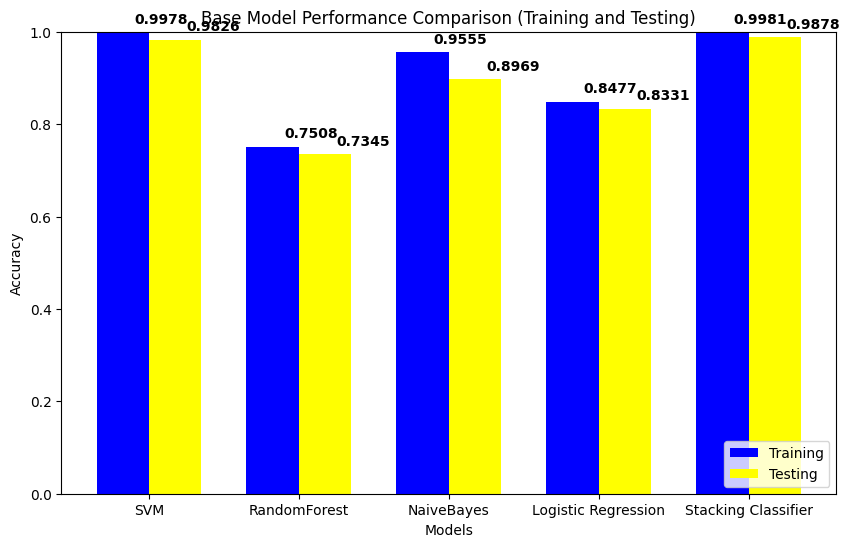

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate and plot the performance of a model
# Plotting the results
bar_width = 0.35
def evaluate_and_plot(model, features_train, y_train, features_test, y_test, label, index):
    # Train the model on the training data
    model.fit(features_train, y_train)

    train_accuracy= model.score(features_train, y_train)
    test_accuracy= model.score(features_test, y_test)

    plt.bar(index, [train_accuracy, test_accuracy], bar_width, label='Training' if index == 0 else '', color='blue')
    plt.bar(index + bar_width, [0, test_accuracy], bar_width, label='Testing' if index == 0 else '', color='yellow')

    # Adds text labels for accuracy scores
    plt.text(index + bar_width / 2 - 0.1, train_accuracy + 0.02, f'{train_accuracy:.4f}', color='black', fontweight='bold')
    plt.text(index + bar_width * 1.5 - 0.1, test_accuracy + 0.02, f'{test_accuracy:.4f}', color='black', fontweight='bold')

# Evaluate and plot the base models
plt.figure(figsize=(10, 6))  # Set the size of the figure

# Index values for positioning the bars
index = np.arange(5)

evaluate_and_plot(model, features_train, y_train, features_test, y_test, 'SVM', index[0])
evaluate_and_plot(model2, features_train, y_train, features_test, y_test, 'RandomForest', index[1])
evaluate_and_plot(nb_classifier, features_train, y_train, features_test, y_test, 'NaiveBayes', index[2])
evaluate_and_plot(meta_model, features_train, y_train, features_test, y_test, 'Logistic Regression', index[3])
evaluate_and_plot(stacking_classifier, features_train, y_train, features_test, y_test, 'Logistic Regression', index[4])


# Add labels, title, legend, and adjust layout
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Base Model Performance Comparison (Training and Testing)')
plt.xticks(index + bar_width / 2, ['SVM', 'RandomForest', 'NaiveBayes', 'Logistic Regression', 'Stacking Classifier'])
plt.legend(loc='lower right')
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1 for accuracy
plt.show()


In [ ]:
# Define the text to preprocess
email_text_to_test = ["Hey mat, we need to go through with the decision on Friday by the latest ."]
email_text_to_test = [lemmatize_text(text) for text in email_text_to_test]
email_features = cv.transform(email_text_to_test)
prediction = stacking_classifier.predict(email_features)
print(prediction[0])
if prediction[0] == "ham":
    print("The email is not spam.")
else:
    print("The email is spam.")

ham
The email is not spam.


In [ ]:
email_text_to_test2 = ["A virus has been detected on your system. Dial the number and we will quickly resolve this. "]
preprocessed_email_text = [lemmatize_text(text) for text in email_text_to_test2]

email_features = cv.transform(preprocessed_email_text)
prediction2 = stacking_classifier.predict(email_features)
if prediction2[0] == "ham":
    print("The email is not spam.")
else:
    print("The email is spam.")

The email is spam.


In [ ]:
# Prompt the user to confirm the prediction
user_input = input("Was this accurate? (yes/no): ").lower()


if user_input == "yes":

    new_row = {'Body': email_text_to_test[0], 'Label': prediction[0]}
    spam = spam.append(new_row, ignore_index=True)

else:
    # If the user confirms it's spam or provides a different label, add it to the DataFrame with the correct label
    correct_label = input("Enter the correct label (e.g., 'ham' or 'spam'): ").strip().lower()
    new_row = {'Body': email_text_to_test[0], 'Label': correct_label}
    spam = spam.append(new_row, ignore_index=True)
    print(f"The email is added as '{correct_label}' to the dataset.")

# Now, df contains the updated dataset with the user's feedback.

allows user to confirm if the classifier worked or not. It will send the message back into the dataset so the model can train on it.

In [ ]:
import pickle
with open("stacking_classifier.pkl", "wb") as f:
   pickle.dump(stacking_classifier, f)


# to save the fitted tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(cv, handle, protocol=pickle.HIGHEST_PROTOCOL)

